## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

import pytorch_lightning as pl

In [3]:
from nam.data import *
from nam.config import defaults
from nam.models import NAM, DNN, get_num_units
from nam.engine import Engine

## Configuration 

In [4]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [5]:
config.regression = False
config.batch_size = 2048
config.training_epochs = 1
config.n_models = 4

In [6]:
pl.seed_everything(config.seed)

Global seed set to 1377


1377

## Data

In [7]:
df = pd.read_csv('data/GALLUP.csv')

In [8]:
df.head(3)

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,4,1.800488,Israel,18042.77108,1.0,15.0,2016,32658.020
1,4,2.360024,Israel,12799.41274,1.0,15.0,2013,31369.909
2,8,1.463117,Israel,22448.93600,1.0,15.0,2015,32038.697


In [9]:
df["WP16"] = np.where(df["WP16"] < 6, 0, 1)

In [10]:
dataset = NAMDataset.from_df(config,
                             df, 
                             features_columns=["income_2", "WP1219", "WP1220", 
                                               "year", "weo_gdpc_con_ppp"],
                             targets_column='WP16',
                             weights_column='wgt')

In [11]:
dataset

NAMDatasetSample(
	features=tensor([-1.0000,  1.0000, -0.4773, -0.5000, -0.9039]), 
	targets=1, 
	weights=0.13806897401809692
)

In [12]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [13]:
len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset)

(965384, 107264, 268161)

---
---

## NAM models

In [14]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
      num_outputs=int(dataset.targets.max().item() + 1),
)

In [15]:
import copy
engines = [Engine(config, copy.deepcopy(model)) for _ in range(config.n_models)]
# engine

In [16]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

In [17]:
trainer = pl.Trainer(
    default_root_dir=f"{config.output_dir}/{model.name}",
    max_epochs=config.training_epochs,
    callbacks=[checkpoint_callback],
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [18]:
for engine in engines:
    trainer.fit(model=engine, train_dataloader=train_dl, val_dataloaders=val_dl)


  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 155 K 
1 | metrics | Accuracy | 0     
-------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]


  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 155 K 
1 | metrics | Accuracy | 0     
-------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 471it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]


  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 155 K 
1 | metrics | Accuracy | 0     
-------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 471it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]


  | Name    | Type     | Params
-------------------------------------
0 | model   | NAM      | 155 K 
1 | metrics | Accuracy | 0     
-------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 471it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [19]:
for engine in engines:
    trainer.test(model=engine, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5903175473213196,
 'test_acc_epoch': 0.5889186263084412,
 'test_loss': 0.6584086418151855,
 'test_loss_epoch': 0.665676474571228}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5804268717765808,
 'test_acc_epoch': 0.5885158777236938,
 'test_loss': 0.6626684069633484,
 'test_loss_epoch': 0.6651544570922852}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5799062848091125,
 'test_acc_epoch': 0.5886948704719543,
 'test_loss': 0.6608187556266785,
 'test_loss_epoch': 0.6647951006889343}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5897969603538513,
 'test_acc_epoch': 0.592353105545044,
 'test_loss': 0.6621238589286804,
 'test_loss_epoch': 0.6634833216667175}
--------------------------------------------------------------------------------


In [20]:
models = [engine.model for engine in engines]

In [21]:
from nam.utils.graphing import *

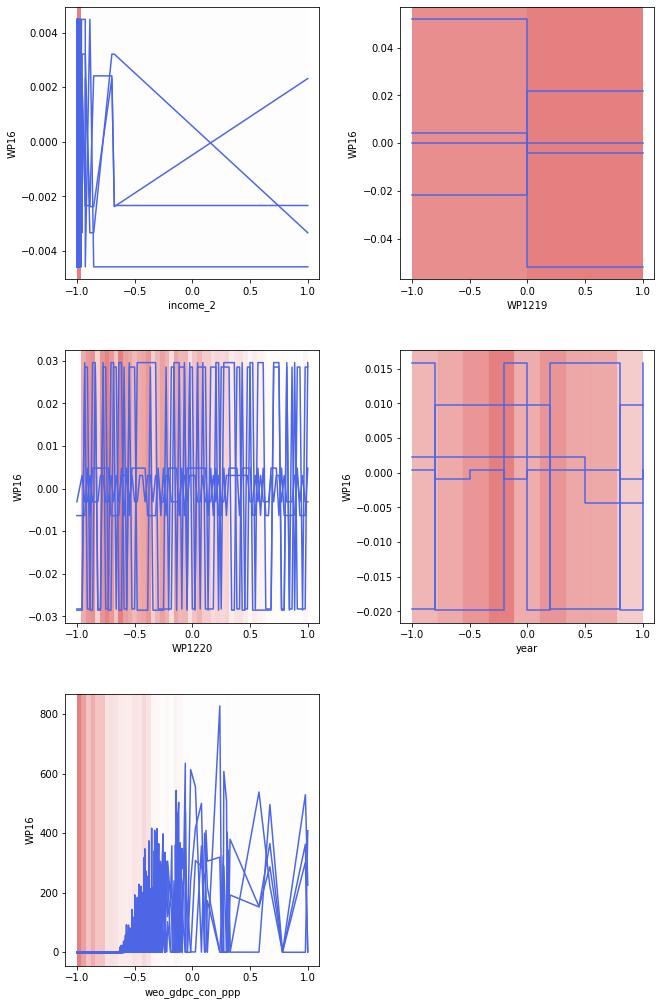

In [22]:
nam_plot(dataset, models)

In [23]:
ds2 = dataset
ds2

NAMDatasetSample(
	features=tensor([-1.0000,  1.0000, -0.8409,  0.7500, -0.9689]), 
	targets=0, 
	weights=0.11908714473247528
)

In [24]:
ds2.data

,WP16,wgt,country,income_2,WP1219,WP1220,year,weo_gdpc_con_ppp
0,0,1.800488,Israel,18042.771080,1.0,15.0,2016,32658.020
1,0,2.360024,Israel,12799.412740,1.0,15.0,2013,31369.909
2,1,1.463117,Israel,22448.936000,1.0,15.0,2015,32038.697
3,0,1.246618,Israel,16853.739740,1.0,15.0,2014,31844.204
4,1,1.800488,Israel,22206.487490,1.0,15.0,2016,32658.020
...,...,...,...,...,...,...,...,...
1340804,0,0.569955,Zimbabwe,566.020845,1.0,100.0,2017,2079.190
1340805,0,0.533722,Zimbabwe,453.127896,1.0,100.0,2014,2134.776
1340806,0,1.286156,Zimbabwe,0.000000,1.0,100.0,2011,1920.745
1340807,0,0.643078,Zimbabwe,2869.777740,1.0,100.0,2011,1920.745


In [25]:
ds2.features = torch.tensor(np.array(ds2.data[ds2.data.columns[3:]])).float()

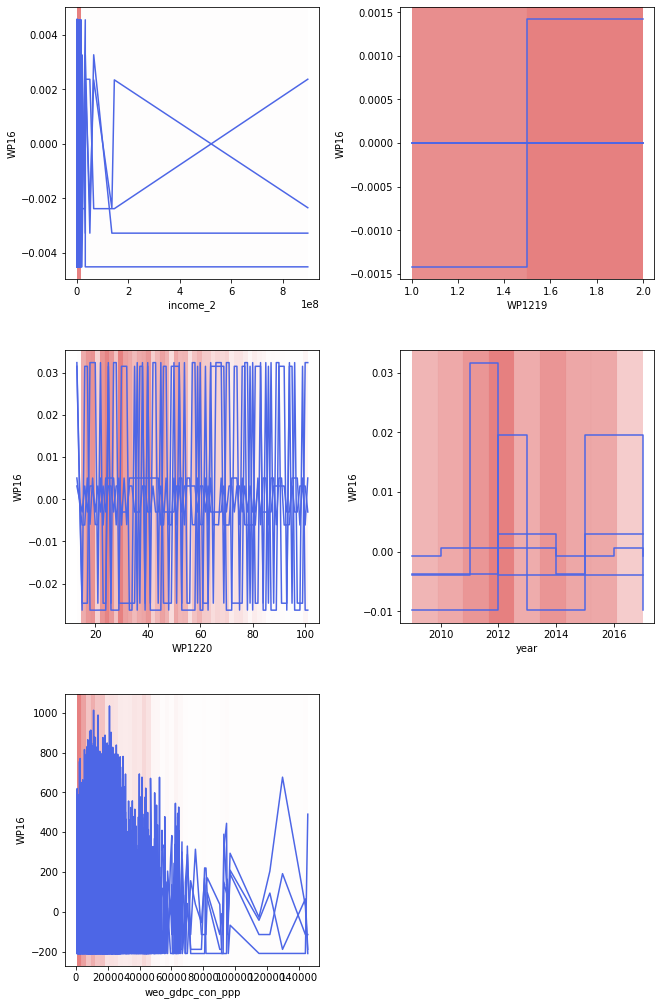

In [26]:
nam_plot(ds2, models)